In [37]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
import torch.amp as amp
print(torch.cuda.is_available())  # Should return True if CUDA is enabled
print(torch.__version__)  # Check the installed PyTorch version
print(torch.version.cuda)  # Check CUDA version used by PyTorch

z = 1
dpival = 2000
cmapname = "summer"
font = {'family': 'serif', 'serif': ['Computer Modern']}
line = {'linewidth': 2/z, 'linestyle' : 'solid'}
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **font)  # pass in the font dict as kwargs
matplotlib.rc('font', weight='bold')  # pass in the font dict as kwargs
matplotlib.rc('lines', **line)
matplotlib.rc('axes', labelsize=20/z, labelweight = 'bold')
matplotlib.rc('legend', fontsize=15/z, frameon=False)
matplotlib.rc('xtick.major', size=2/z)
matplotlib.rc('ytick.major', size=2/z)
matplotlib.rc('xtick', labelsize=20/z, direction='in')
matplotlib.rc('ytick', labelsize=20/z, direction='in')

True
2.4.1
12.4


In [3]:
class ResNet(nn.Module):
    def __init__(self, input_dim=2, index_dim=1, hidden_dim=64, out_dim=2, n_hidden_layers=20):
        super().__init__()
        self.act = nn.SiLU()
        self.n_hidden_layers = n_hidden_layers

        # Input dimension is input_dim plus time embedding dimension (index_dim)
        in_dim = input_dim + index_dim

        layers = []
        # First layer: from (input_dim + index_dim) to hidden_dim
        layers.append(nn.Linear(in_dim, hidden_dim))
        # Hidden layers: each layer takes hidden_dim concatenated with time (index_dim) and outputs hidden_dim
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_dim + index_dim, hidden_dim))
        # Final layer: from (hidden_dim + index_dim) to output dimension
        layers.append(nn.Linear(hidden_dim + index_dim, out_dim))
        
        self.layers = nn.ModuleList(layers)

    def _append_time(self, h, t):
        # Append the log of time to each feature vector
        time_embedding = torch.log(t).to(device)
        return torch.cat([h, time_embedding.reshape(-1, 1)], dim=1)

    def forward(self, u, t):
        # Initial layer: append time to input u and apply the first linear layer with activation
        h = self.act(self.layers[0](self._append_time(u, t)))
        # Process through hidden layers with residual connections
        for i in range(self.n_hidden_layers):
            h_new = self.layers[i + 1](self._append_time(h, t))
            h = self.act(h + h_new)
        # Final layer: append time and compute output
        return self.layers[-1](self._append_time(h, t))

# Create an instance of the ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Generation

Mean is  tensor([ 1.7070e-04, -1.0003e+00], device='cuda:0')
Standard Deviation is  tensor([5.1559, 5.0071], device='cuda:0')


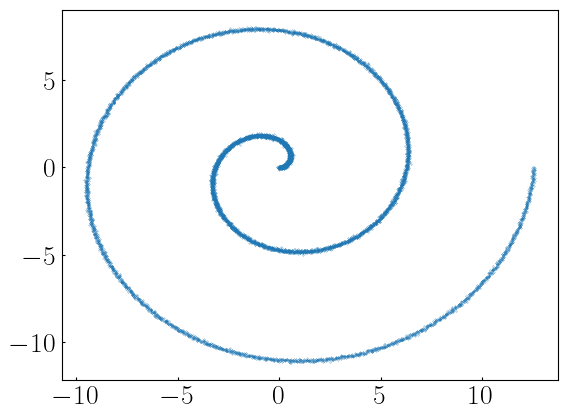

In [30]:
def generate_spiral(n_points=2000, noise=0.05):
    t = np.linspace(0, 4 * np.pi, n_points)  # Spiral parameter
    x = t * np.cos(t) + np.random.normal(scale=noise, size=n_points)  # X-coordinates
    y = t * np.sin(t) + np.random.normal(scale=noise, size=n_points)  # Y-coordinates
    return np.stack([x, y], axis=1)

spiral_data = generate_spiral(n_points=10000, noise=0.05)
spiral_tensor = torch.tensor(spiral_data, dtype=torch.float32).to(device).view(-1, d)
plt.scatter(spiral_data[:,0], spiral_data[:,1], s=0.05)
universal_mean = torch.mean(spiral_tensor, axis=0)
universal_std = torch.std(spiral_tensor, axis =0)
print("Mean is ", universal_mean)
print("Standard Deviation is ", universal_std)

# Passive Sampling and Loss for d-dimensional Data

In [5]:
# ====================================
# 2. Function to Sample Noisy Data at Time t
# ====================================
def sample_data_at_time_t(x0, T, t):
    t = t.view(-1, 1, 1)  # Reshape for broadcasting
    mean_t = x0 * torch.exp(-t)  # Mean at time t
    var_t = T * (1 - torch.exp(-2 * t)) + 1e-8  # 🔥 Prevents division by zero

    # Sample from Normal distribution
    noise = torch.randn_like(x0) * torch.sqrt(var_t)
    x_t = mean_t + noise

    return x_t

# 3. Def Loss Function
def diffusion_loss(model, x0, T, t):
    device = x0.device
    t = t.view(-1, 1)  # Reshape for broadcasting
    mean_t = x0 * torch.exp(-t)  # Mean at time t
    var_t = T * (1 - torch.exp(-2 * t)) + 1e-8  # 🔥 Prevents division by batch_randn
    # Sample from No-rmal distribution*
    batch_randn = torch.randn_like(x0)
    noise = batch_randn * torch.sqrt(var_t)
    
    # Sample noisy data at time t
    xt = mean_t + noise
    
    # Compute correction term: l = -(xt - mean_xt) / var_xt
    #l = -(xt - mean_t)
    l = batch_randn
    with torch.amp.autocast("cuda"):
        loss = (-torch.sqrt(var_t)*model(xt, t) - l) ** 2
        loss = torch.mean(torch.sum(loss.reshape(loss.shape[0], -1), dim=-1))

    return loss

# Active Sampling and Loss for d-dimensional data

In [6]:
# ====================================
# 1. Generate Correlated Gaussian Noise
# ====================================
def generate_correlated_noise(covariance_matrix, d=2):
    """
    Generate correlated Gaussian noise using Cholesky decomposition.
    Args:
        covariance_matrix (torch.Tensor): A [batch_size, 2, 2] covariance matrix.
    Returns:
        torch.Tensor: Correlated noise of shape [batch_size, 2].
    """
    noise_x_list = []
    noise_eta_list = []
    for _ in range(d):
        batch_size = covariance_matrix.shape[0]
        # Perform Cholesky decomposition to get lower triangular matrix L
        L = torch.linalg.cholesky(covariance_matrix)  # Shape: [batch_size, 2, 2]
        # Generate uncorrelated standard normal noise
        uncorrelated_noise = torch.randn(batch_size, 2, 1).to(covariance_matrix.device)  # Shape: [batch_size, 2, 1]
        # Apply the Cholesky factor to obtain correlated noise
        correlated_noise = torch.bmm(L, uncorrelated_noise).squeeze(-1)  # Shape: [batch_size, 2]
        noise_x_list.append(correlated_noise[:,0])
        noise_eta_list.append(correlated_noise[:,1])
    noise_x = torch.stack(noise_x_list, dim=1)
    noise_eta = torch.stack(noise_eta_list, dim=1)
    return noise_x, noise_eta

# ====================================
# 2. Compute Covariance Matrix Components
# ====================================
def compute_covariance(Tp, Ta, tau, k, t):
    a = torch.exp(-k * t)
    b = torch.exp(-t / tau)
    Tx = Tp
    Ty = Ta / (tau * tau)
    w = 1 / tau
    M11 = (1/k)*Tx*(1-a*a) + (1/k)*Ty*( 1/(w*(k+w)) + 4*a*b*k/((k+w)*(k-w)**2) - (k*b*b + w*a*a)/(w*(k-w)**2) )
    M12 = (Ty/(w*(k*k - w*w))) * ( k*(1-b*b) - w*(1 + b*b - 2*a*b) )
    M22 = (Ty/w)*(1-b*b)
    # Stack elements correctly to match batch dimension
    cov_matrix = torch.stack([
        torch.cat([M11, M12], dim=1),  # First row: [M11, M12]
        torch.cat([M12, M22], dim=1)   # Second row: [M12, M22]
    ], dim=1)  # Stack along second dimension to form [batch, 2, 2]
    return cov_matrix  # Shape: (batch_size, 2, 2)

# ====================================
# 3. Sample Noisy Data at Time t
# ====================================
def sample_data_active(x0, eta0, t, Tp, Ta, tau, k, d=2):
    #t = t.view(-1, 1)  # Ensure proper shape
    cov_mat = compute_covariance(Tp, Ta, tau, k, t)  # Now correctly shaped (batch_size, 2, 2)
    a = torch.exp(-k * t)
    b = (torch.exp(-t / tau) - torch.exp(-k * t)) / (k - (1 / tau))
    c = torch.exp(-t / tau)
    mean_x = a * x0 + b * eta0
    mean_eta = c * eta0
    # Generate correlated Gaussian noise using the updated covariance matrix
    noise_x, noise_eta = generate_correlated_noise(cov_mat, d=d)
    return mean_x + noise_x, mean_eta + noise_eta, noise_x, noise_eta

# ====================================
# 4. Define Loss Function
# ====================================
def diffusion_loss_active(model_eta, x0, eta0, Tp, Ta, tau, k, t, d=2):
    #x0, eta0, t = x0.float(), eta0.float(), t.view(-1, 1).float()  # Ensure types
    xt, etat, batch_randn_x, batch_randn_eta = sample_data_active(x0, eta0, t, Tp, Ta, tau, k, d=d)
    xin = torch.cat((xt, etat), dim=-1).float()
    a = torch.exp(-k * t)
    b = (torch.exp(-t / tau) - torch.exp(-k * t)) / (k - (1 / tau))
    c = torch.exp(-t / tau)

    M = compute_covariance(Tp, Ta, tau, k, t)
    M11 = M[:, 0, 0].view(-1,1)
    M12 = M[:, 0, 1].view(-1,1)
    M22 = M[:, 1, 1].view(-1,1)
    det = M11 * M22 - M12 * M12

    a = a.view(-1,1)
    b = b.view(-1,1)
    c = c.view(-1,1)

    #Fx = (1 / det) * (-M22 * (xt - a * x0 - b * eta0) + M12 * (etat - c * eta0))
    #Feta = (1 / det) * (-M11 * (etat - c * eta0) + M12 * (xt - a * x0 - b * eta0))
    #scr_x = model_x(xin, t)
    #scr_eta = model_eta(xin, t)
    
    #Fx = (-M22 * (xt - a * x0 - b * eta0) + M12 * (etat - c * eta0))
    Feta = torch.sqrt(1/det)*(-M11 * (etat - c * eta0) + M12 * (xt - a * x0 - b * eta0))
    #scr_x = det*model_x(xin, t)
    scr_eta = torch.sqrt(det)*model_eta(xin, t)

    #loss_x = torch.mean((scr_x - Fx) ** 2)
    loss_eta = torch.mean((scr_eta - Feta) ** 2)

    return loss_eta

# Restarting

In [40]:
restart_epoch = 0
T = torch.tensor(1.0, device=device)
Tp = torch.tensor(1e-3, device=device)
Ta = torch.tensor(1.0, device=device)
tau = torch.tensor(0.5, device=device)

num_components = "spiral"
d = 2

model_pas = ResNet(input_dim=d, index_dim=1, hidden_dim=64, out_dim=d, n_hidden_layers=20)
model_act = ResNet(input_dim=2*d, index_dim=1, hidden_dim=64, out_dim=d, n_hidden_layers=20)

fname_pas = "Passive_models_{}_T_{}".format(num_components, T.cpu().numpy())
fname_act = "Active_models_{}_Ta_{}_tau_{}".format(num_components, Ta.cpu().numpy(), tau.cpu().numpy())
if not os.path.exists(fname_pas):
    os.mkdir(fname_pas)
else:
    if os.path.exists('{}/model_at_epoch_{}.pth'.format(fname_pas, restart_epoch)):
        checkpoint_pas = torch.load('{}/model_at_epoch_{}.pth'.format(fname_pas, restart_epoch), weights_only=True)
        model_pas.load_state_dict(checkpoint_pas['model_state_dict'])
        print("Passive model loaded")
        
if not os.path.exists(fname_act):
    os.mkdir(fname_act)
else:
    if os.path.exists('{}/model_at_epoch_{}.pth'.format(fname_act, restart_epoch)):
        checkpoint_act = torch.load('{}/model_at_epoch_{}.pth'.format(fname_act, restart_epoch), weights_only=True)
        model_act.load_state_dict(checkpoint_act['model_state_dict'])
        print("Active model loaded")

# Training the models

In [41]:
# ====================================
# 5. Initialize Model & Train with Mini-batch SGD
# ====================================
# Define the optimizer (SGD instead of Adam)
device = "cuda"
model_pas = model_pas.to(device)
model_act = model_act.to(device)
optimizer_pas = optim.Adam(model_pas.parameters(), lr=1e-3)  # 🔥 SGD with Momentum
optimizer_act = optim.Adam(model_act.parameters(), lr=1e-3)

scaler = torch.amp.GradScaler(device)

# Create Mini-batches using DataLoader
nsamples = 512
batch_size = 512 # Define mini-batch size
num_epochs = 10000
import torch.amp as amp

# Use the new API, specifying the device type explicitly.
#scaler = amp.GradScaler("cuda")
scaler = amp.GradScaler(device)
for epoch in range(num_epochs):
    spiral_data_t0 = generate_spiral(n_points=512, noise=0.05)
    spiral_tensor = torch.tensor(spiral_data_t0, dtype=torch.float32).to(device).view(-1, d)
    # Compute mean and standard deviation
    mean = spiral_tensor.mean()
    std = spiral_tensor.std()    
    # Normalize dataset
    normalized_spiral_tensor = (spiral_tensor - universal_mean) / universal_std
    normalized_spiral_tensor = normalized_spiral_tensor.to(device)
    gaussian_data_eta = np.random.multivariate_normal(
        mean=np.zeros(d),  # Zero mean for both dimensions
        cov=np.diag((Ta.cpu().numpy()/tau.cpu().numpy())*np.ones(d)),  # Diagonal covariance matrix
        size=nsamples  # Number of samples
    )
    g_tensor_eta = torch.tensor(gaussian_data_eta, dtype=torch.float32).view(-1, d)
    g_tensor_eta = g_tensor_eta.to(device).view(-1, d)
    # Wrap it back into a TensorDataset
    dataset = TensorDataset(normalized_spiral_tensor, g_tensor_eta)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    total_loss_pas = 0.0
    total_loss_act = 0.0
    
    num_batches = len(dataloader)

    for x0_batch, eta0_batch in dataloader:
        x0 = x0_batch.to(device=device)
        x0 = x0.to(torch.float32)
        eta0 = eta0_batch.to(device=device)
        t = 1e-3 + (2.0 - 1e-3) * torch.rand(x0.shape[0], device=device)
        t = t.to(device).view(-1,1)
        #t = torch.rand(x0.shape[0], device=device)
        # Use the new autocast API with the device specified.
        with torch.amp.autocast(device):
            loss_pas = diffusion_loss(model_pas, x0, T, t)
            loss_act = diffusion_loss_active(model_act, x0, eta0, Tp, Ta, tau, 1.0, t, d=d)

        if torch.isnan(loss_pas) or torch.isnan(loss_act):
            print(f"⚠️ Loss became NaN at epoch {epoch}, stopping training!")
            break

        optimizer_pas.zero_grad()
        optimizer_act.zero_grad()
        loss_pas.backward()
        loss_act.backward()
        optimizer_pas.step()
        optimizer_act.step()
        #scaler.scale(loss_pas).backward()
        #scaler.unscale_(optimizer_pas)
        #torch.nn.utils.clip_grad_norm_(model_pas.parameters(), max_norm=10.0)
        #scaler.step(optimizer_pas)
        #scaler.scale(loss_act).backward()
        #scaler.unscale_(optimizer_act)
        #torch.nn.utils.clip_grad_norm_(model_act.parameters(), max_norm=10.0)
        #scaler.step(optimizer_act)
        #scaler.update()

        total_loss_pas += loss_pas.item()
        total_loss_act += loss_act.item()

    avg_loss_pas = total_loss_pas / num_batches
    avg_loss_act = total_loss_act / num_batches
    print(f"Epoch [{epoch}/{num_epochs}], Average Loss, Passive: {avg_loss_pas:.6f}, Active: {avg_loss_act:.6f}")
    if (epoch+1)%100 == 0:
        torch.save({
        'model_state_dict': model_pas.state_dict(),  # Model weights
        'epoch': epoch,  # Epoch
    }, 'Passive_models_{}_T_{}/model_at_epoch_{}.pth'.format(num_components, T, epoch))
    if (epoch+1)%100 == 0:
        torch.save({
        'model_state_dict': model_act.state_dict(),  # Model weights
        'epoch': epoch,  # Epoch
    }, 'Active_models_{}_Ta_{}_tau_{}/model_at_epoch_{}.pth'.format(num_components, Ta, tau, epoch))


Epoch [0/10000], Average Loss, Passive: 1.960197, Active: 0.322128
Epoch [1/10000], Average Loss, Passive: 1.907447, Active: 0.314995
Epoch [2/10000], Average Loss, Passive: 1.946437, Active: 0.341869
Epoch [3/10000], Average Loss, Passive: 2.059157, Active: 0.316182
Epoch [4/10000], Average Loss, Passive: 1.979928, Active: 0.312924
Epoch [5/10000], Average Loss, Passive: 1.948342, Active: 0.425903
Epoch [6/10000], Average Loss, Passive: 1.994109, Active: 0.317059
Epoch [7/10000], Average Loss, Passive: 1.993940, Active: 0.292275
Epoch [8/10000], Average Loss, Passive: 2.112198, Active: 0.344099
Epoch [9/10000], Average Loss, Passive: 1.980315, Active: 0.314836
Epoch [10/10000], Average Loss, Passive: 1.777205, Active: 0.339945
Epoch [11/10000], Average Loss, Passive: 1.899859, Active: 0.321170
Epoch [12/10000], Average Loss, Passive: 2.124435, Active: 0.334357
Epoch [13/10000], Average Loss, Passive: 1.917856, Active: 0.305655
Epoch [14/10000], Average Loss, Passive: 1.959065, Active: